### Seasonal ARIMA

In [62]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
from params import *
%matplotlib inline
rcParams['figure.figsize'] = 15, 6

len(hw_full)

22169

In [63]:
y = hw_full

# The 'MS' string groups the data in buckets by start of the month
y = y['W [cm]'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

len(y)

729

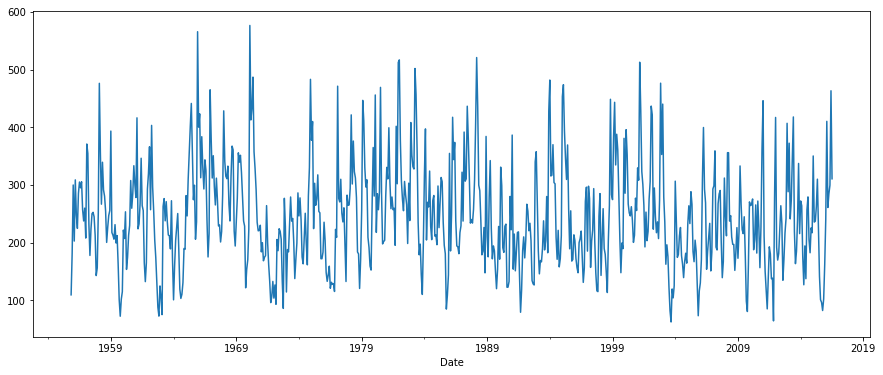

In [64]:
y.plot(figsize=(15, 6))
plt.show()

In [65]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [66]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

# choose random value to initiate the aic_value and param, param_seasonal
aic_value = 9000  
opt_param = (0,0,0)
opt_param_seasonal = (0,0,0)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if (results.aic < aic_value):
                aic_value = results.aic
                opt_param = param
                opt_param_seasonal = param_seasonal
        except:
            continue
            
print (opt_param, opt_param_seasonal, aic_value)

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:9478.194014562607
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:8258.435371282543
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:8732.849625143012
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:8422.56771814248
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:8478.857891715877
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:8252.148509482808
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:9481.162075837154
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8999.586351341495
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:8580.99601251538
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:8056.824676779856
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:8558.400677867136
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:8195.295775861088
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:8315.056878583458
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8056.467851673933
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:8304.10143492815
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:8156.1775552944855
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:8314.559749217096
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:8305.916792560154
ARIMA(0, 1, 

In [67]:
# choose the AIC with the lowest value
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6599      0.054     12.217      0.000       0.554       0.766
ma.L1         -0.1473      0.069     -2.120      0.034      -0.284      -0.011
ma.S.L12      -1.0073      0.063    -15.942      0.000      -1.131      -0.883
sigma2      4624.0356    386.367     11.968      0.000    3866.771    5381.300


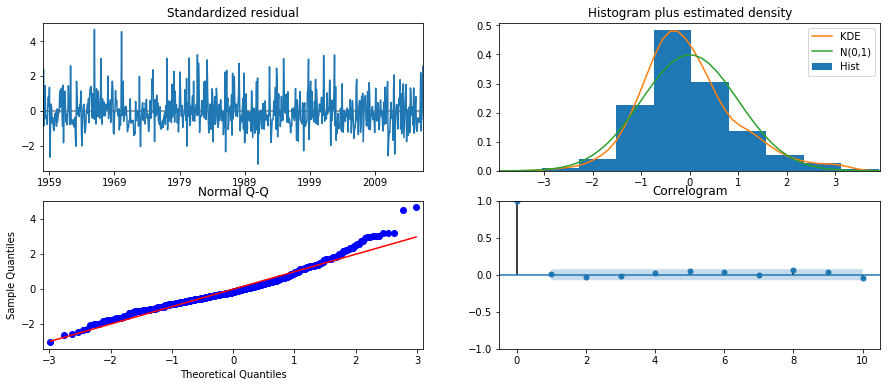

In [68]:
results.plot_diagnostics(figsize=(15, 6))
plt.show()

In [69]:
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

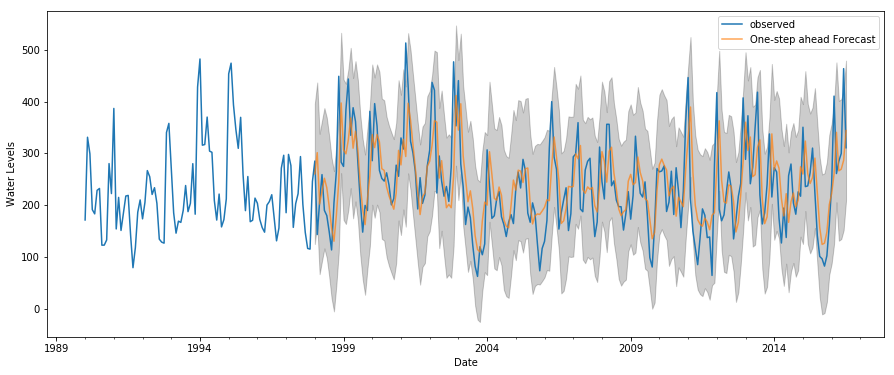

In [70]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Water Levels')
plt.legend()

plt.show()

In [71]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4770.18


### Warning Notice: the Mean Squared Error is extrem large

In [72]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

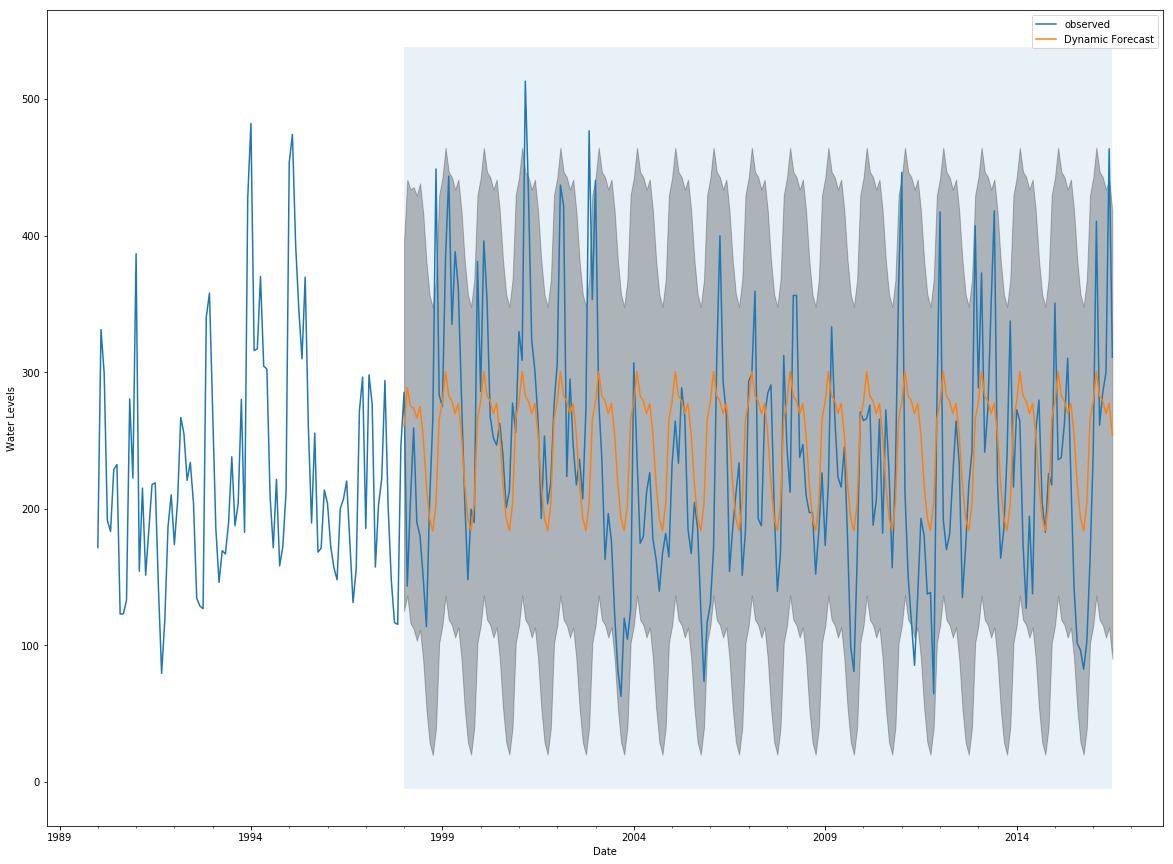

In [73]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Water Levels')

plt.legend()
plt.show()

In [74]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 6489.76


### Warning Notice: the Mean Squared Error is extrem large and even larger than 'One-step ahead Forecast'


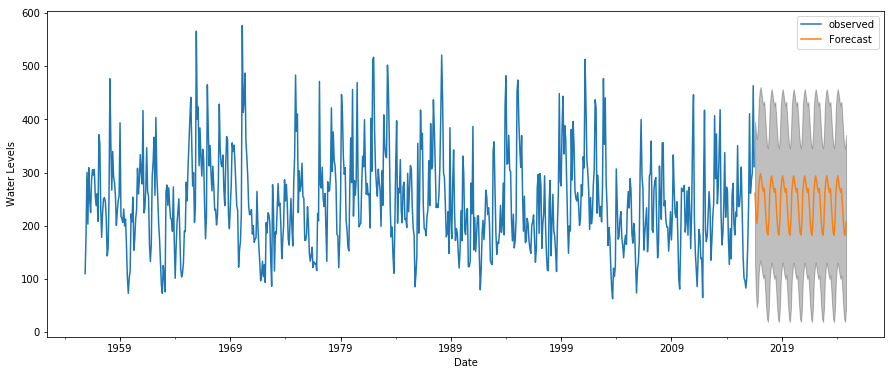

In [75]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(15, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Water Levels')

plt.legend()
plt.show()

### Reference
https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3